## Table des Matières

1. [Introduction](#introduction)
2. [Étape 1 : Importer les Bibliothèques Nécessaires](#étape-1--importer-les-bibliothèques-nécessaires)
3. [Étape 2 : Définir les Fonctions de Prétraitement et d’Augmentation](#étape-3--définir-la-fonction-de-création-des-modèles)
4. [Étape 3 : Définir la Fonction de Création des Modèles](#étape-3--définir-la-fonction-de-création-des-modèles)
5. [Étape 4 : Définir la Fonction de Téléchargement Audio depuis YouTube](#etape-4--definir-la-fonction-de-telechargement-audio-depuis-youtube)
6. [Étape 5 : Initialiser les Hyperparamètres](#etape-5--initialiser-les-hyperparametres)
7. [Étape 6 : Charger et Prétraiter les Données](#etape-6--charger-et-pretraiter-les-donnees)
8. [Étape 7 : Itérer sur les Combinaisons d'Hyperparamètres et Entraîner les Modèles](#etape-7--iterer-sur-les-combinaisons-dhyperparametres-et-entrainer-les-modeles)
9. [Étape 8 : Analyser et Sauvegarder les Résultats](#etape-8--analyser-et-sauvegarder-les-resultats)
10. [Étape 9 : Visualiser les Meilleurs Résultats](#etape-9--visualiser-les-meilleurs-resultats)
11. [Étape 10 : Sauvegarder et Charger les Meilleurs Modèles](#etape-10--sauvegarder-et-charger-les-meilleurs-modeles)
12. [Étape 11 : Prédiction sur de Nouveaux Échantillons](#etape-11--prediction-sur-de-nouveaux-echantillons)

## Introduction

Dans ce notebook, nous allons :

1. **Charger et prétraiter les données audio** en extrayant les caractéristiques MFCC avec augmentation de données.
2. **Définir et entraîner différents modèles** (CNN 2D, CNN profond, RNN avec LSTM/GRU) en testant diverses combinaisons d'hyperparamètres tels que la taille du batch, le nombre d'époques, le taux d'apprentissage et le nombre de coefficients MFCC.
3. **Évaluer les performances** de chaque modèle et collecter les métriques dans un tableau pour une analyse comparative.
4. **Visualiser les meilleurs résultats** et **sauvegarder les modèles** optimaux pour une utilisation future.

## Étape 1 : Importer les Bibliothèques Nécessaires

Tout d’abord, importons toutes les bibliothèques nécessaires pour le prétraitement des données, la création des modèles, et l’évaluation des performances.

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LSTM, GRU, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import yt_dlp as youtube_dl

# Pour afficher les graphiques directement dans le notebook
%matplotlib inline

## Étape 2 : Définir les Fonctions de Prétraitement et d’Augmentation

Nous allons définir les fonctions nécessaires pour :

- **Augmenter les données audio** (ajout de bruit, modification de la hauteur et de la vitesse).
- **Padder ou tronquer les MFCCs** pour assurer une longueur fixe.
- **Extraire les MFCCs** avec augmentation.

In [2]:
def augment_audio(audio, sr):
    """
    Applique des augmentations sur l'audio : ajout de bruit, modification de la hauteur et de la vitesse.
    """
    # Ajout de bruit
    noise = np.random.randn(len(audio)) * 0.005
    audio_with_noise = audio + noise

    # Modifier la hauteur en fréquence
    try:
        pitch_factor = np.random.uniform(-5, 5)  # En demi-tons
        audio_pitch_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_factor)
    except:
        audio_pitch_shifted = audio

    # Modifier la vitesse
    try:
        audio_stretched = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    except:
        audio_stretched = audio

    return [audio_with_noise, audio_pitch_shifted, audio_stretched]

def pad_or_truncate_mfcc(mfccs, fixed_length):
    """
    Ajuste la longueur des MFCCs (n_mfcc, T) à (n_mfcc, fixed_length)
    - Tronque si T > fixed_length
    - Ajoute du padding (zéros) si T < fixed_length
    """
    length = mfccs.shape[1]
    if length > fixed_length:
        mfccs = mfccs[:, :fixed_length]
    elif length < fixed_length:
        pad_width = fixed_length - length
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    return mfccs

def extract_features_with_augmentation(file_path, fixed_length, n_mfcc=40):
    """
    Extrait les MFCCs d'un fichier audio avec augmentation de données.
    """
    try:
        audio, sr = librosa.load(file_path, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs = pad_or_truncate_mfcc(mfccs, fixed_length)

        # Augmentations
        augmented_audios = augment_audio(audio, sr)
        augmented_mfccs = []
        for a in augmented_audios:
            m = librosa.feature.mfcc(y=a, sr=sr, n_mfcc=n_mfcc)
            m = pad_or_truncate_mfcc(m, fixed_length)
            augmented_mfccs.append(m)

        # On renvoie la liste (original + augmentations) directement sous forme (n_mfcc, T)
        all_mfccs = [mfccs] + augmented_mfccs
        return all_mfccs
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file_path}: {e}")
        return []

## Étape 3 : Définir la Fonction de Création des Modèles

Nous allons définir une fonction qui crée différents types de modèles en fonction des hyperparamètres spécifiés.

In [3]:
def create_model(model_type, input_shape, num_classes, learning_rate=0.001):
    """
    Crée un modèle de deep learning en fonction du type spécifié.
    """
    model = Sequential()
    
    if model_type == 'CNN_2D_basic':
        # Modèle CNN 2D de base avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'CNN_2D_deep':
        # Modèle CNN 2D plus profond avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'CRNN':
        # Modèle Convolutional Recurrent Neural Network avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(64))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'CNN_1D':
        # Modèle CNN 1D avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'RNN_LSTM':
        # Modèle avec couches LSTM
        # Reshape pour LSTM : (N, T, n_mfcc)
        model.add(Flatten(input_shape=input_shape))  # Convertir en séquence pour LSTM
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.3))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(64))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'RNN_GRU':
        # Modèle avec couches GRU
        # Reshape pour GRU : (N, T, n_mfcc)
        model.add(Flatten(input_shape=input_shape))  # Convertir en séquence pour GRU
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.3))
        model.add(GRU(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(64))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    else:
        raise ValueError(f"Type de modèle inconnu: {model_type}")

    # Compilation du modèle
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


## Étape 4 : Définir la Fonction de Téléchargement Audio depuis YouTube

Cette fonction permet de télécharger un fichier audio depuis une URL YouTube pour tester les prédictions.

In [4]:
def download_youtube_audio(youtube_url, output_path="downloaded_audio.wav"):
    """
    Télécharge l'audio d'une vidéo YouTube et le sauvegarde en fichier WAV.
    """
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': 'temp_audio.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
    }

    # Télécharger l'audio
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])

    # Renommer le fichier pour l'utiliser
    if os.path.exists("temp_audio.wav"):
        os.rename("temp_audio.wav", output_path)
        print(f"Audio téléchargé et sauvegardé sous : {output_path}")
    else:
        print("Erreur lors du téléchargement.")


## Étape 5 : Initialiser les Hyperparamètres

Définissons les différentes valeurs des hyperparamètres que nous allons tester.

In [5]:
# Définition des hyperparamètres à tester
batch_sizes = [16, 32, 64]
epochs_list = [20, 50, 100]
learning_rates = [0.001, 0.0001, 0.00001]
model_types = ['CNN_2D_basic', 'CNN_2D_deep', 'CRNN', 'RNN_LSTM', 'RNN_GRU']  # Ajouter d'autres modèles si nécessaire
n_mfcc_values = [20, 40, 60]  # "token size" interprété comme nombre de MFCCs

# Préparation du tableau de résultats
results = []

# Créer un répertoire pour sauvegarder les modèles
os.makedirs('models', exist_ok=True)


## Étape 6 : Charger et Prétraiter les Données

Pour chaque valeur de `n_mfcc`, nous chargerons et prétraiterons les données audio avec augmentation.

In [6]:
def load_audio_features_with_augmentation(data_path, fixed_length, n_mfcc=40):
    """
    Charge les features audio avec augmentation et ajuste les MFCCs à une longueur fixe.
    """
    genres = os.listdir(data_path)
    X_list = []
    y_list = []

    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)
            mfccs_list = extract_features_with_augmentation(file_path, fixed_length=fixed_length, n_mfcc=n_mfcc)
            for m in mfccs_list:
                # m est de forme (n_mfcc, fixed_length)
                X_list.append(m)
                y_list.append(genre)

    X = np.array(X_list)  # X: (N, n_mfcc, fixed_length)
    y = np.array(y_list)

    # Ajout de la dimension "canal" pour le CNN 2D : (N, n_mfcc, fixed_length, 1)
    X = X[..., np.newaxis]
    return X, y


## Étape 7 : Itérer sur les Combinaisons d'Hyperparamètres et Entraîner les Modèles

Nous allons maintenant itérer sur toutes les combinaisons possibles d'hyperparamètres et de types de modèles, entraîner chaque modèle, évaluer ses performances, et enregistrer les résultats.

In [7]:
def model_exists(n_mfcc, model_type, batch_size, epochs, lr):
    """
    Vérifie si le modèle avec les hyperparamètres spécifiés existe déjà.
    """
    model_save_path = f"models/n_mfcc_{n_mfcc}/{model_type}_bs{batch_size}_ep{epochs}_lr{lr}.keras"
    return os.path.exists(model_save_path)

In [8]:
# Chemin vers les données audio
data_path = "Data/genres_original"

# Définir fixed_length en fonction de n_mfcc et des paramètres de vos MFCC
fixed_length = 1293  # À ajuster selon votre dataset (en fonction du sr et hop_length)

# Itération sur les différentes valeurs de n_mfcc (token size)
for n_mfcc in n_mfcc_values:
    print(f"\nTraitement pour n_mfcc = {n_mfcc}")
    
    # Charger les données avec augmentation
    X, y = load_audio_features_with_augmentation(data_path, fixed_length, n_mfcc=n_mfcc)

    print(f"Shape des données: X={X.shape}, y={y.shape}")
    
    # Encodage des labels
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=len(encoder.classes_))

    # Sauvegarder l'encodeur pour ce n_mfcc
    encoder_save_path = f"models/n_mfcc_{n_mfcc}/label_encoder.joblib"
    os.makedirs(os.path.dirname(encoder_save_path), exist_ok=True)
    joblib.dump(encoder, encoder_save_path)

    # Split des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Sauvegarder les données de test
    test_data_path = f"models/n_mfcc_{n_mfcc}/X_test.npy"
    test_labels_path = f"models/n_mfcc_{n_mfcc}/y_test.npy"
    np.save(test_data_path, X_test)
    np.save(test_labels_path, y_test)

    # Normalisation des données
    # Par exemple, vous pouvez normaliser les MFCCs entre 0 et 1
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_test)

    # Itération sur les différentes combinaisons d'hyperparamètres
    for model_type, batch_size, epochs, lr in itertools.product(model_types, batch_sizes, epochs_list, learning_rates):
        print(f"Entraînement du modèle: {model_type}, Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {lr}")
        
        # Définir le chemin de sauvegarde du modèle
        model_save_path = f"models/n_mfcc_{n_mfcc}/{model_type}_bs{batch_size}_ep{epochs}_lr{lr}.keras"
        
        # Vérifier si le modèle existe déjà
        if model_exists(n_mfcc, model_type, batch_size, epochs, lr):
            print(f"Le modèle {model_type} avec bs={batch_size}, ep={epochs}, lr={lr} existe déjà. Passage au suivant.")
            continue  # Passer à la prochaine combinaison
        
        # Créer le répertoire si nécessaire
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        
        # Définir le callback EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Définir un ModelCheckpoint pour sauvegarder le meilleur modèle
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
        
        # Définir le modèle
        input_shape = X_train.shape[1:]  # (n_mfcc, fixed_length, 1)
        num_classes = len(encoder.classes_)
        model = create_model(model_type, input_shape, num_classes, learning_rate=lr)

        # Entraîner le modèle
        history = model.fit(
            X_train, y_train, 
            validation_split=0.2, 
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[early_stopping, checkpoint], 
            verbose=1  # Vous pouvez changer en 0 pour moins de sorties
        )

        # Évaluer le modèle
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        val_loss = min(history.history['val_loss'])
        val_accuracy = max(history.history['val_accuracy'])

        # Prédictions pour les métriques supplémentaires
        y_pred = np.argmax(model.predict(X_test), axis=-1)
        y_true = np.argmax(y_test, axis=-1)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        # Enregistrer les résultats
        result = {
            'n_mfcc': n_mfcc,
            'model_type': model_type,
            'batch_size': batch_size,
            'epochs': epochs,
            'learning_rate': lr,
            'accuracy': accuracy,
            'loss': loss,
            'validation_accuracy': val_accuracy,
            'validation_loss': val_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        results.append(result)
        print(f"Résultat: {result}")

        # Sauvegarder les résultats après chaque entraînement pour éviter les pertes en cas d'interruption
        results_df = pd.DataFrame(results)
        results_df.to_csv('model_results.csv', index=False)
        print("Résultats sauvegardés dans 'model_results.csv'.")


Traitement pour n_mfcc = 20


/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_67541/1932264053.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=30)
/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erreur lors du traitement du fichier Data/genres_original/jazz/jazz.00054.wav: 
Shape des données: X=(3996, 20, 1293, 1), y=(3996,)
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 20, Learning Rate: 0.001
Le modèle CNN_2D_basic avec bs=16, ep=20, lr=0.001 existe déjà. Passage au suivant.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 20, Learning Rate: 0.0001
Le modèle CNN_2D_basic avec bs=16, ep=20, lr=0.0001 existe déjà. Passage au suivant.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 20, Learning Rate: 1e-05
Le modèle CNN_2D_basic avec bs=16, ep=20, lr=1e-05 existe déjà. Passage au suivant.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 50, Learning Rate: 0.001
Le modèle CNN_2D_basic avec bs=16, ep=50, lr=0.001 existe déjà. Passage au suivant.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 50, Learning Rate: 0.0001
Le modèle CNN_2D_basic avec bs=16, ep=50, lr=0.0001 existe déjà. Passage au suivant.
Entraînem

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-10 09:40:54.292578: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-10 09:40:54.292619: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-10 09:40:54.292627: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-10 09:40:54.292656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-10 09:40:54.292667: I tensorflow/core/common_runtime/pluggable_device/pl

Epoch 1/100


2024-12-10 09:40:55.532965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-12-10 09:40:55.539959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2080 - loss: 2.1763
Epoch 1: val_accuracy improved from -inf to 0.09219, saving model to models/n_mfcc_20/CRNN_bs16_ep100_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.2083 - loss: 2.1757 - val_accuracy: 0.0922 - val_loss: 2.3065
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3945 - loss: 1.8010
Epoch 2: val_accuracy improved from 0.09219 to 0.10312, saving model to models/n_mfcc_20/CRNN_bs16_ep100_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.3945 - loss: 1.8008 - val_accuracy: 0.1031 - val_loss: 2.3571
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4799 - loss: 1.5583
Epoch 3: val_accuracy improved from 0.10312 to 0.11406, saving model to models/n_mfcc_20/CRNN_bs16_ep100_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.4801 - loss: 1.5579 - val_accuracy: 0.1141 - val_loss: 2.3617
Epoch 4/100
160/160 ━━━━━━━━━━━━━━

2024-12-10 09:44:56.068555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 16, 'epochs': 100, 'learning_rate': 0.0001, 'accuracy': 0.7250000238418579, 'loss': 0.8685907125473022, 'validation_accuracy': 0.6812499761581421, 'validation_loss': 1.0463191270828247, 'precision': 0.7867377746449726, 'recall': 0.725, 'f1_score': 0.7313006988190169}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 16, Epochs: 100, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1590 - loss: 2.2643
Epoch 1: val_accuracy improved from -inf to 0.08906, saving model to models/n_mfcc_20/CRNN_bs16_ep100_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1592 - loss: 2.2640 - val_accuracy: 0.0891 - val_loss: 2.3111
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2694 - loss: 2.1158
Epoch 2: val_accuracy improved from 0.08906 to 0.14844, saving model to models/n_mfcc_20/CRNN_bs16_ep100_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.2695 - loss: 2.1156 - val_accuracy: 0.1484 - val_loss: 2.2785
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3197 - loss: 1.9930
Epoch 3: val_accuracy improved from 0.14844 to 0.20312, saving model to models/n_mfcc_20/CRNN_bs16_ep100_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.3197 - loss: 1.9929 - val_accuracy: 0.2031 - val_loss: 2.1906
Epoch 4/100
160/160 ━━━━━

2024-12-10 09:58:04.404539: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 16, 'epochs': 100, 'learning_rate': 1e-05, 'accuracy': 0.737500011920929, 'loss': 0.8262173533439636, 'validation_accuracy': 0.707812488079071, 'validation_loss': 0.9273269772529602, 'precision': 0.78884878511047, 'recall': 0.7375, 'f1_score': 0.7409553181862915}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 32, Epochs: 20, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2001 - loss: 2.1661
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CRNN_bs32_ep20_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.2008 - loss: 2.1646 - val_accuracy: 0.1000 - val_loss: 2.3623
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3606 - loss: 1.7370
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.3604 - loss: 1.7370 - val_accuracy: 0.1000 - val_loss: 2.3744
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4145 - loss: 1.5808
Epoch 3: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4148 - loss: 1.5804 - val_accuracy: 0.1000 - val_loss: 2.5990
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4823 - loss: 1.4192
Epoch 4: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/ste

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1696 - loss: 2.2234

2024-12-10 09:59:12.401436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CRNN_bs32_ep20_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.1703 - loss: 2.2223 - val_accuracy: 0.1000 - val_loss: 2.3185
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3599 - loss: 1.8951
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.3600 - loss: 1.8947 - val_accuracy: 0.1000 - val_loss: 2.3289
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4583 - loss: 1.6742
Epoch 3: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.4585 - loss: 1.6737 - val_accuracy: 0.1000 - val_loss: 2.3261
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5482 - loss: 1.4631
Epoch 4: val_accuracy improved from 0.10000 to 0.10781, saving model to models/n_mfcc_20/CRNN_bs32_ep20_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.

2024-12-10 10:01:49.932100: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0001, 'accuracy': 0.7537500262260437, 'loss': 0.7791954278945923, 'validation_accuracy': 0.7093750238418579, 'validation_loss': 0.9727972149848938, 'precision': 0.7894010307495795, 'recall': 0.75375, 'f1_score': 0.7536306749519588}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 32, Epochs: 20, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1326 - loss: 2.2923
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CRNN_bs32_ep20_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.1329 - loss: 2.2920 - val_accuracy: 0.0812 - val_loss: 2.3136
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2289 - loss: 2.1817
Epoch 2: val_accuracy improved from 0.08125 to 0.08906, saving model to models/n_mfcc_20/CRNN_bs32_ep20_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.2290 - loss: 2.1815 - val_accuracy: 0.0891 - val_loss: 2.3296
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2915 - loss: 2.0925
Epoch 3: val_accuracy did not improve from 0.08906
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.2917 - loss: 2.0923 - val_accuracy: 0.0891 - val_loss: 2.3211
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3388 - loss: 2.0028
Epoch 4: val_accuracy 

2024-12-10 10:04:56.313236: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 32, 'epochs': 20, 'learning_rate': 1e-05, 'accuracy': 0.4712499976158142, 'loss': 1.558312177658081, 'validation_accuracy': 0.4671874940395355, 'validation_loss': 1.5670803785324097, 'precision': 0.5522186238096239, 'recall': 0.47125, 'f1_score': 0.44384628432636863}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 32, Epochs: 50, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2045 - loss: 2.1428
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CRNN_bs32_ep50_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.2051 - loss: 2.1415 - val_accuracy: 0.1000 - val_loss: 2.5652
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3685 - loss: 1.7675
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.3687 - loss: 1.7669 - val_accuracy: 0.1000 - val_loss: 2.9850
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4289 - loss: 1.5789
Epoch 3: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.4291 - loss: 1.5786 - val_accuracy: 0.1000 - val_loss: 2.9137
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5042 - loss: 1.4310
Epoch 4: val_accuracy improved from 0.10000 to 0.10156, saving model to models/n_mfcc_2

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


2024-12-10 10:05:56.802632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2011 - loss: 2.2043
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CRNN_bs32_ep50_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.2019 - loss: 2.2030 - val_accuracy: 0.1000 - val_loss: 2.3387
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3889 - loss: 1.8691
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.3891 - loss: 1.8685 - val_accuracy: 0.1000 - val_loss: 2.4253
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4741 - loss: 1.6523
Epoch 3: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.4742 - loss: 1.6517 - val_accuracy: 0.1000 - val_loss: 2.4640
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5365 - loss: 1.4365
Epoch 4: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - acc

2024-12-10 10:09:07.148717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.0001, 'accuracy': 0.7137500047683716, 'loss': 0.9330236911773682, 'validation_accuracy': 0.660937488079071, 'validation_loss': 1.1307579278945923, 'precision': 0.7758654934642837, 'recall': 0.71375, 'f1_score': 0.7150943855951649}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 32, Epochs: 50, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1444 - loss: 2.2694
Epoch 1: val_accuracy improved from -inf to 0.08906, saving model to models/n_mfcc_20/CRNN_bs32_ep50_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.1449 - loss: 2.2690 - val_accuracy: 0.0891 - val_loss: 2.3047
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2617 - loss: 2.1576
Epoch 2: val_accuracy improved from 0.08906 to 0.10156, saving model to models/n_mfcc_20/CRNN_bs32_ep50_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.2619 - loss: 2.1573 - val_accuracy: 0.1016 - val_loss: 2.3047
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3156 - loss: 2.0544
Epoch 3: val_accuracy did not improve from 0.10156
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.3156 - loss: 2.0541 - val_accuracy: 0.0938 - val_loss: 2.3065
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3444 - loss: 1.9542
Epoch 4: val_accuracy did

2024-12-10 10:15:50.707169: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 32, 'epochs': 50, 'learning_rate': 1e-05, 'accuracy': 0.6612499952316284, 'loss': 1.0719647407531738, 'validation_accuracy': 0.629687488079071, 'validation_loss': 1.1803133487701416, 'precision': 0.7285904890172712, 'recall': 0.66125, 'f1_score': 0.6583362900223473}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 32, Epochs: 100, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.2001 - loss: 2.2110
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CRNN_bs32_ep100_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.2007 - loss: 2.2097 - val_accuracy: 0.0812 - val_loss: 2.3859
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3122 - loss: 1.9025
Epoch 2: val_accuracy improved from 0.08125 to 0.10000, saving model to models/n_mfcc_20/CRNN_bs32_ep100_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.3127 - loss: 1.9014 - val_accuracy: 0.1000 - val_loss: 2.3453
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4058 - loss: 1.6320
Epoch 3: val_accuracy improved from 0.10000 to 0.14687, saving model to models/n_mfcc_20/CRNN_bs32_ep100_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.4060 - loss: 1.6317 - val_accuracy: 0.1469 - val_loss: 2.3384
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━

2024-12-10 10:17:03.099399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'accuracy': 0.11749999970197678, 'loss': 2.3767385482788086, 'validation_accuracy': 0.22343750298023224, 'validation_loss': 2.338387966156006, 'precision': 0.03927902035707227, 'recall': 0.1175, 'f1_score': 0.04725959392269446}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 32, Epochs: 100, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1623 - loss: 2.2297
Epoch 1: val_accuracy improved from -inf to 0.14687, saving model to models/n_mfcc_20/CRNN_bs32_ep100_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.1630 - loss: 2.2287 - val_accuracy: 0.1469 - val_loss: 2.2992
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3392 - loss: 1.9483
Epoch 2: val_accuracy did not improve from 0.14687
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.3395 - loss: 1.9476 - val_accuracy: 0.1000 - val_loss: 2.3065
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4399 - loss: 1.7083
Epoch 3: val_accuracy improved from 0.14687 to 0.15469, saving model to models/n_mfcc_20/CRNN_bs32_ep100_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.4400 - loss: 1.7079 - val_accuracy: 0.1547 - val_loss: 2.2980
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5010 - loss: 1.5463
Epoch 4: val_acc

2024-12-10 10:20:04.056857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.0001, 'accuracy': 0.7699999809265137, 'loss': 0.7312696576118469, 'validation_accuracy': 0.7203124761581421, 'validation_loss': 0.8732792139053345, 'precision': 0.8019322077407888, 'recall': 0.77, 'f1_score': 0.7702117968867861}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 32, Epochs: 100, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1446 - loss: 2.2700
Epoch 1: val_accuracy improved from -inf to 0.10469, saving model to models/n_mfcc_20/CRNN_bs32_ep100_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.1450 - loss: 2.2697 - val_accuracy: 0.1047 - val_loss: 2.3020
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2148 - loss: 2.1777
Epoch 2: val_accuracy did not improve from 0.10469
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.2152 - loss: 2.1773 - val_accuracy: 0.1000 - val_loss: 2.3002
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2982 - loss: 2.0833
Epoch 3: val_accuracy did not improve from 0.10469
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.2982 - loss: 2.0830 - val_accuracy: 0.1016 - val_loss: 2.2944
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3256 - loss: 1.9859
Epoch 4: val_accuracy did not improve from 0.10469
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101m

2024-12-10 10:27:54.837782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 32, 'epochs': 100, 'learning_rate': 1e-05, 'accuracy': 0.5975000262260437, 'loss': 1.2087761163711548, 'validation_accuracy': 0.565625011920929, 'validation_loss': 1.2923450469970703, 'precision': 0.6844294637301408, 'recall': 0.5975, 'f1_score': 0.5931003627959551}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 64, Epochs: 20, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.1874 - loss: 2.1966
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CRNN_bs64_ep20_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.1887 - loss: 2.1939 - val_accuracy: 0.1000 - val_loss: 2.4714
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3942 - loss: 1.7726
Epoch 2: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.3946 - loss: 1.7707 - val_accuracy: 0.1000 - val_loss: 2.9020
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5210 - loss: 1.3816
Epoch 3: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.5209 - loss: 1.3819 - val_accuracy: 0.0750 - val_loss: 2.6845
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5890 - loss: 1.1784
Epoch 4: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.1856 - loss: 2.2204
Epoch 1: val_accuracy improved from -inf to 0.08906, saving model to models/n_mfcc_20/CRNN_bs64_ep20_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.1871 - loss: 2.2183 - val_accuracy: 0.0891 - val_loss: 2.3078
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3348 - loss: 1.9125
Epoch 2: val_accuracy did not improve from 0.08906
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.3354 - loss: 1.9116 - val_accuracy: 0.0891 - val_loss: 2.3811
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4198 - loss: 1.7256
Epoch 3: val_accuracy did not improve from 0.08906
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.4200 - loss: 1.7253 - val_accuracy: 0.0891 - val_loss: 2.4075
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5133 - loss: 1.5793
Epoch 4: val_accuracy did not improve from 0.08906
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms

2024-12-10 10:29:26.695809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 64, 'epochs': 20, 'learning_rate': 0.0001, 'accuracy': 0.09375, 'loss': 2.31037974357605, 'validation_accuracy': 0.109375, 'validation_loss': 2.3077735900878906, 'precision': 0.0087890625, 'recall': 0.09375, 'f1_score': 0.016071428571428573}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 64, Epochs: 20, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.1240 - loss: 2.2915
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CRNN_bs64_ep20_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.1246 - loss: 2.2910 - val_accuracy: 0.0812 - val_loss: 2.3016
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2141 - loss: 2.2053
Epoch 2: val_accuracy did not improve from 0.08125
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.2147 - loss: 2.2046 - val_accuracy: 0.0812 - val_loss: 2.3034
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2643 - loss: 2.1143
Epoch 3: val_accuracy improved from 0.08125 to 0.10312, saving model to models/n_mfcc_20/CRNN_bs64_ep20_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.2642 - loss: 2.1143 - val_accuracy: 0.1031 - val_loss: 2.3012
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3040 - loss: 2.0688
Epoch 4: val_accurac

2024-12-10 10:31:47.485968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 64, 'epochs': 20, 'learning_rate': 1e-05, 'accuracy': 0.36250001192092896, 'loss': 1.7858537435531616, 'validation_accuracy': 0.3656249940395355, 'validation_loss': 1.8036264181137085, 'precision': 0.479828184865593, 'recall': 0.3625, 'f1_score': 0.31672569886083085}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 64, Epochs: 50, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2063 - loss: 2.2073
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CRNN_bs64_ep50_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.2074 - loss: 2.2051 - val_accuracy: 0.1000 - val_loss: 2.5212
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3481 - loss: 1.8634
Epoch 2: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.3488 - loss: 1.8616 - val_accuracy: 0.1000 - val_loss: 2.6400
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4549 - loss: 1.5434
Epoch 3: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.4552 - loss: 1.5420 - val_accuracy: 0.1000 - val_loss: 2.6693
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5285 - loss: 1.3170
Epoch 4: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2043 - loss: 2.2134
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CRNN_bs64_ep50_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.2055 - loss: 2.2113 - val_accuracy: 0.1000 - val_loss: 2.3077
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3733 - loss: 1.9057
Epoch 2: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.3736 - loss: 1.9048 - val_accuracy: 0.1000 - val_loss: 2.3609
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4599 - loss: 1.6981
Epoch 3: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.4600 - loss: 1.6976 - val_accuracy: 0.1000 - val_loss: 2.4536
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5079 - loss: 1.5287
Epoch 4: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms

2024-12-10 10:33:18.447652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 64, 'epochs': 50, 'learning_rate': 0.0001, 'accuracy': 0.09000000357627869, 'loss': 2.3295350074768066, 'validation_accuracy': 0.10000000149011612, 'validation_loss': 2.307730197906494, 'precision': 0.0081, 'recall': 0.09, 'f1_score': 0.014862385321100917}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 64, Epochs: 50, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1401 - loss: 2.2805
Epoch 1: val_accuracy improved from -inf to 0.11094, saving model to models/n_mfcc_20/CRNN_bs64_ep50_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.1406 - loss: 2.2801 - val_accuracy: 0.1109 - val_loss: 2.3014
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.2049 - loss: 2.2082
Epoch 2: val_accuracy did not improve from 0.11094
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.2054 - loss: 2.2077 - val_accuracy: 0.0812 - val_loss: 2.3042
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2645 - loss: 2.1305
Epoch 3: val_accuracy did not improve from 0.11094
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.2648 - loss: 2.1303 - val_accuracy: 0.0859 - val_loss: 2.3045
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3026 - loss: 2.0721
Epoch 4: val_accuracy did not improve from 0.11094
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2163 - loss: 2.1950

2024-12-10 10:34:18.454124: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.11250, saving model to models/n_mfcc_20/CRNN_bs64_ep100_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.2175 - loss: 2.1922 - val_accuracy: 0.1125 - val_loss: 2.3746
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3618 - loss: 1.8084
Epoch 2: val_accuracy improved from 0.11250 to 0.12344, saving model to models/n_mfcc_20/CRNN_bs64_ep100_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.3622 - loss: 1.8067 - val_accuracy: 0.1234 - val_loss: 2.3208
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4483 - loss: 1.5079
Epoch 3: val_accuracy did not improve from 0.12344
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.4488 - loss: 1.5071 - val_accuracy: 0.1016 - val_loss: 2.4792
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5250 - loss: 1.3343
Epoch 4: val_accuracy did not improve from 0.12344
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accura

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1858 - loss: 2.2228
Epoch 1: val_accuracy improved from -inf to 0.10469, saving model to models/n_mfcc_20/CRNN_bs64_ep100_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.1872 - loss: 2.2208 - val_accuracy: 0.1047 - val_loss: 2.2960
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3535 - loss: 1.9278
Epoch 2: val_accuracy did not improve from 0.10469
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.3537 - loss: 1.9270 - val_accuracy: 0.1000 - val_loss: 2.3193
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4262 - loss: 1.7402
Epoch 3: val_accuracy did not improve from 0.10469
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.4266 - loss: 1.7395 - val_accuracy: 0.1000 - val_loss: 2.3367
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5038 - loss: 1.5613
Epoch 4: val_accuracy did not improve from 0.10469
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 

2024-12-10 10:35:46.544877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CRNN', 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.0001, 'accuracy': 0.09000000357627869, 'loss': 2.296299457550049, 'validation_accuracy': 0.10468749701976776, 'validation_loss': 2.295980453491211, 'precision': 0.008130489335006274, 'recall': 0.09, 'f1_score': 0.014913693901035672}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CRNN, Batch Size: 64, Epochs: 100, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.1259 - loss: 2.2931
Epoch 1: val_accuracy improved from -inf to 0.10312, saving model to models/n_mfcc_20/CRNN_bs64_ep100_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.1266 - loss: 2.2924 - val_accuracy: 0.1031 - val_loss: 2.3020
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2166 - loss: 2.1989
Epoch 2: val_accuracy improved from 0.10312 to 0.11406, saving model to models/n_mfcc_20/CRNN_bs64_ep100_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.2171 - loss: 2.1984 - val_accuracy: 0.1141 - val_loss: 2.3037
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2852 - loss: 2.1175
Epoch 3: val_accuracy improved from 0.11406 to 0.11875, saving model to models/n_mfcc_20/CRNN_bs64_ep100_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.2852 - loss: 2.1172 - val_accuracy: 0.1187 - val_loss: 2.3114
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "lstm_40" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 256)

**Explications :**

- **Itération sur `n_mfcc`** : Pour chaque valeur de `n_mfcc` (nombre de coefficients MFCC), nous chargeons et prétraitons les données.
- **Normalisation** : Les MFCCs sont normalisés en divisant par leur maximum pour faciliter la convergence du modèle.
- **Boucle Imbriquée** : Utilisation de `itertools.product` pour parcourir toutes les combinaisons possibles des hyperparamètres et des types de modèles.
- **Métriques Supplémentaires** : En plus de la précision et de la perte, nous calculons également la précision (`precision_score`), le rappel (`recall_score`) et le score F1 (`f1_score`) pour une évaluation plus complète.
- **Sauvegarde des Modèles** : Les meilleurs modèles basés sur la précision de validation sont sauvegardés grâce au `ModelCheckpoint`.

## Étape 8 : Analyser et Sauvegarder les Résultats

Après avoir entraîné tous les modèles, nous allons collecter les résultats dans un tableau et les sauvegarder dans un fichier CSV pour une analyse ultérieure.

In [9]:
# Charger le fichier csv des résultats
results_df = pd.read_csv('model_results.csv')
print("Les résultats sont chargés avec succès.")


Les résultats sont chargés avec succès.


## Étape 9 : Visualiser les Meilleurs Résultats

Nous allons afficher les 10 meilleures configurations basées sur la précision de test.

In [10]:
# Afficher les meilleurs résultats
best_results = results_df.sort_values(by='accuracy', ascending=False).head(10)
print("\nTop 10 des meilleures configurations :")
display(best_results)


Top 10 des meilleures configurations :


,n_mfcc,model_type,batch_size,epochs,learning_rate,accuracy,loss,validation_accuracy,validation_loss,precision,recall,f1_score
15,20,CNN_2D_basic,32,100,0.0010,0.88875,0.469222,0.820312,0.606798,0.896033,0.88875,0.889629
31,20,CNN_2D_deep,16,50,0.0001,0.87625,0.388959,0.839063,0.493998,0.881816,0.87625,0.877019
33,20,CNN_2D_deep,16,100,0.0010,0.86750,0.478962,0.857813,0.500029,0.875386,0.86750,0.867582
37,20,CNN_2D_deep,32,20,0.0001,0.86375,0.452014,0.823438,0.592623,0.881576,0.86375,0.865719
9,20,CNN_2D_basic,32,20,0.0010,0.86375,0.541110,0.843750,0.599895,0.873622,0.86375,0.864497
12,20,CNN_2D_basic,32,50,0.0010,0.85500,0.500971,0.829687,0.720109,0.864506,0.85500,0.854494
40,20,CNN_2D_deep,32,50,0.0001,0.85375,0.427489,0.815625,0.572117,0.877822,0.85375,0.857315
6,20,CNN_2D_basic,16,100,0.0010,0.85000,0.571241,0.834375,0.696354,0.861165,0.85000,0.850079
34,20,CNN_2D_deep,16,100,0.0001,0.84875,0.575023,0.828125,0.606385,0.862128,0.84875,0.849487
24,20,CNN_2D_basic,64,100,0.0010,0.84875,0.568541,0.848437,0.647980,0.859395,0.84875,0.848930


### Visualisation des Résultats

Pour mieux comprendre les performances des différents modèles et hyperparamètres, nous pouvons créer des visualisations.

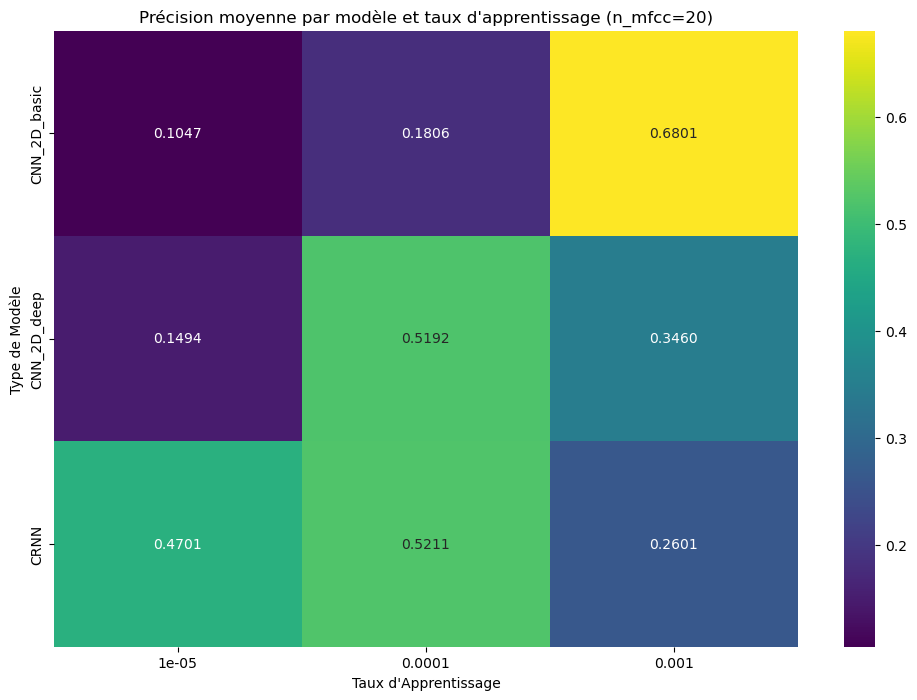

Aucune donnée disponible pour n_mfcc = 40. Passage au suivant.
Aucune donnée disponible pour n_mfcc = 60. Passage au suivant.


In [11]:
# Heatmap de la précision en fonction du modèle et du taux d'apprentissage pour chaque n_mfcc
for n_mfcc in n_mfcc_values:
    subset = results_df[results_df['n_mfcc'] == n_mfcc]
    
    if subset.empty:
        print(f"Aucune donnée disponible pour n_mfcc = {n_mfcc}. Passage au suivant.")
        continue
    
    pivot_table = subset.pivot_table(values='accuracy', index='model_type', columns='learning_rate', aggfunc='mean')
    
    if pivot_table.empty:
        print(f"Aucun résultat après pivot pour n_mfcc = {n_mfcc}.")
        continue
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis')
    plt.title(f"Précision moyenne par modèle et taux d'apprentissage (n_mfcc={n_mfcc})")
    plt.ylabel("Type de Modèle")
    plt.xlabel("Taux d'Apprentissage")
    plt.show()


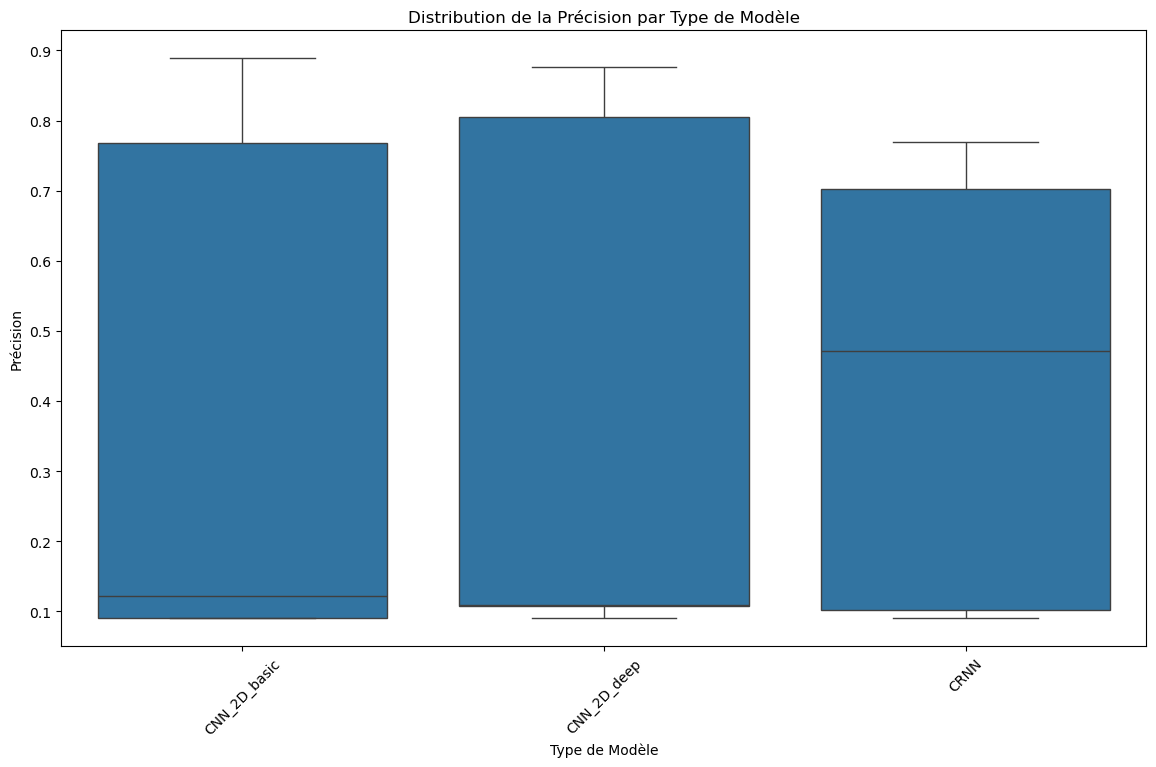

In [12]:
# Boxplot de la précision par type de modèle
plt.figure(figsize=(14, 8))
sns.boxplot(x='model_type', y='accuracy', data=results_df)
plt.title("Distribution de la Précision par Type de Modèle")
plt.xlabel("Type de Modèle")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.show()


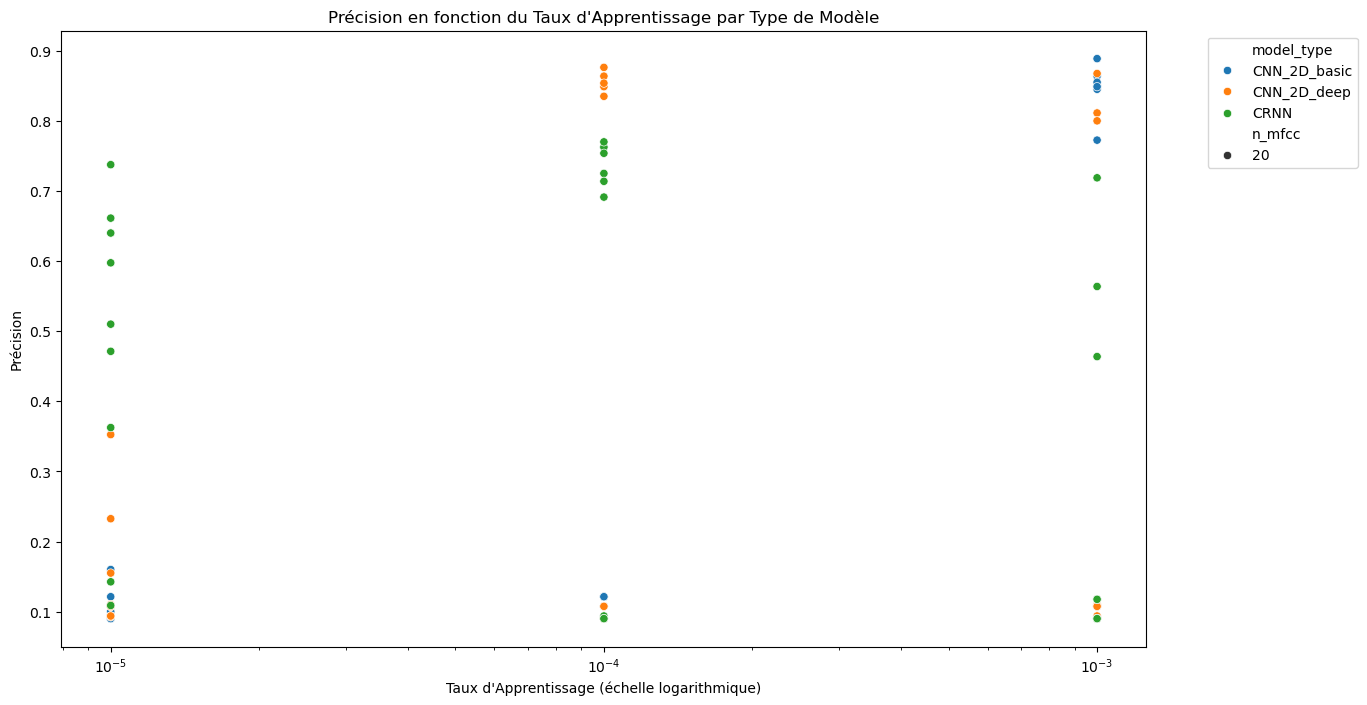

In [13]:
# Scatter plot de la précision en fonction du taux d'apprentissage pour chaque modèle
plt.figure(figsize=(14, 8))
sns.scatterplot(x='learning_rate', y='accuracy', hue='model_type', style='n_mfcc', data=results_df)
plt.xscale('log')
plt.title("Précision en fonction du Taux d'Apprentissage par Type de Modèle")
plt.xlabel("Taux d'Apprentissage (échelle logarithmique)")
plt.ylabel("Précision")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


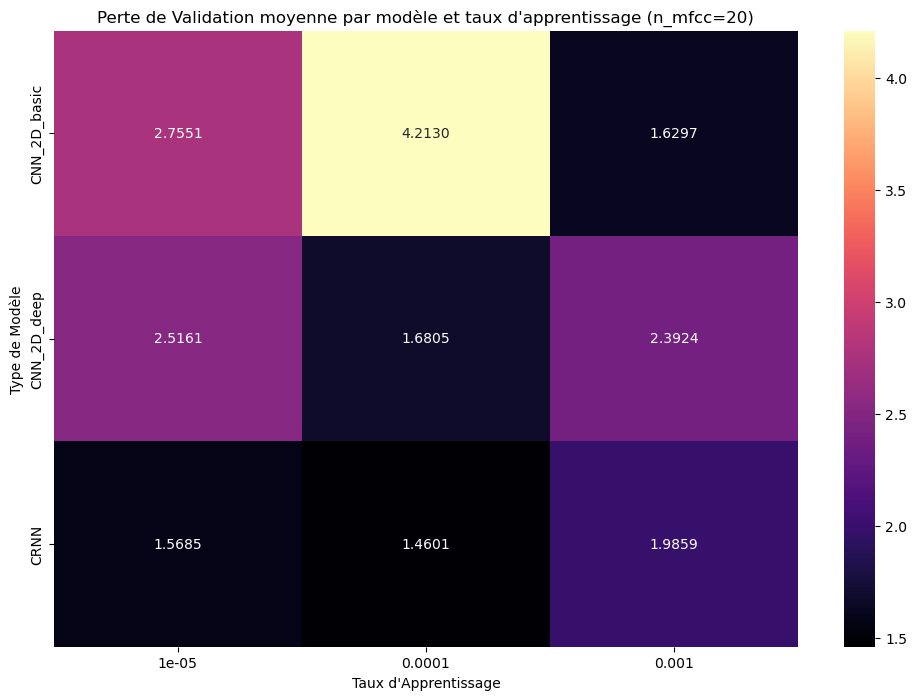

Aucune donnée disponible pour n_mfcc = 40. Passage au suivant.
Aucune donnée disponible pour n_mfcc = 60. Passage au suivant.


In [14]:
# Heatmap de la perte de validation par modèle et taux d'apprentissage pour chaque n_mfcc
for n_mfcc in n_mfcc_values:
    subset = results_df[results_df['n_mfcc'] == n_mfcc]
    
    if subset.empty:
        print(f"Aucune donnée disponible pour n_mfcc = {n_mfcc}. Passage au suivant.")
        continue
    
    pivot_table = subset.pivot_table(values='validation_loss', index='model_type', columns='learning_rate', aggfunc='mean')
    
    if pivot_table.empty:
        print(f"Aucun résultat après pivot pour n_mfcc = {n_mfcc}.")
        continue
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='magma')
    plt.title(f"Perte de Validation moyenne par modèle et taux d'apprentissage (n_mfcc={n_mfcc})")
    plt.ylabel("Type de Modèle")
    plt.xlabel("Taux d'Apprentissage")
    plt.show()

**Explications :**

- **Heatmap de la Précision** : Compare la précision moyenne pour chaque type de modèle et taux d'apprentissage, segmenté par `n_mfcc`.
- **Boxplot de la Précision** : Montre la distribution de la précision pour chaque type de modèle, permettant d'identifier la variabilité et les performances médianes.
- **Scatter Plot de la Précision** : Visualise la relation entre le taux d'apprentissage et la précision, avec une distinction par type de modèle et `n_mfcc`.
- **Boxplot du Score F1** : Permet de visualiser la distribution du score F1, une métrique équilibrée entre précision et rappel.
- **Heatmap de la Perte de Validation** : Compare la perte de validation moyenne pour chaque type de modèle et taux d'apprentissage, segmenté par `n_mfcc`.

## Étape 10 : Évaluation Approfondie

Pour une évaluation plus complète, calculons des métriques supplémentaires telles que le rapport de classification (classification report) et les courbes ROC (si applicable).

### 10.1. Rapport de Classification

Le rapport de classification fournit la précision, le rappel et le score F1 pour chaque classe.

In [15]:
# Sélectionner le meilleur modèle basé sur la précision
best_result = results_df.sort_values(by='accuracy', ascending=False).iloc[0]
best_model_path = f"models/n_mfcc_{best_result['n_mfcc']}/{best_result['model_type']}_bs{best_result['batch_size']}_ep{best_result['epochs']}_lr{best_result['learning_rate']}.keras"
best_model = load_model(best_model_path)
print(f"\nChargement du meilleur modèle : {best_model_path}")

# Charger l'encodeur et les données de test correspondant au meilleur modèle
encoder_save_path = f"models/n_mfcc_{best_result['n_mfcc']}/label_encoder.joblib"
test_data_path = f"models/n_mfcc_{best_result['n_mfcc']}/X_test.npy"
test_labels_path = f"models/n_mfcc_{best_result['n_mfcc']}/y_test.npy"

if os.path.exists(encoder_save_path) and os.path.exists(test_data_path) and os.path.exists(test_labels_path):
    encoder = joblib.load(encoder_save_path)
    X_test = np.load(test_data_path)
    y_test = np.load(test_labels_path)
    
    # Normalisation des données de test (si ce n'est pas déjà fait)
    X_test = X_test / np.max(X_test)
    
    # Re-évaluer pour obtenir le rapport de classification
    y_pred = np.argmax(best_model.predict(X_test), axis=-1)
    y_true = np.argmax(y_test, axis=-1)
    
    print("\nRapport de Classification pour le Meilleur Modèle :")
    print(classification_report(y_true, y_pred, target_names=encoder.classes_, zero_division=0))
else:
    print("Les fichiers d'encodeur ou de données de test pour le meilleur modèle n'ont pas été trouvés.")




Chargement du meilleur modèle : models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr0.001.keras


2024-12-10 10:38:32.687050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Rapport de Classification pour le Meilleur Modèle :
              precision    recall  f1-score   support

       blues       0.82      0.91      0.86        78
   classical       1.00      0.90      0.95        81
     country       0.87      0.79      0.82        84
       disco       0.88      0.84      0.86        86
      hiphop       0.92      0.84      0.88        70
        jazz       0.91      0.91      0.91        75
       metal       0.88      0.93      0.91        72
         pop       0.91      0.90      0.90        97
      reggae       0.93      0.91      0.92        82
        rock       0.74      0.89      0.81        75

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.89      0.88      0.88       800



### 10.2. Courbes ROC et AUC

Pour chaque classe, nous pouvons tracer les courbes ROC et calculer l'AUC. Cependant, cela nécessite des prédictions en probabilités et une binarisation des labels.

**Note** : Les courbes ROC sont plus pertinentes pour des problèmes de classification binaire. Pour des classes multiples, nous utilisons une approche "un contre tous".

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


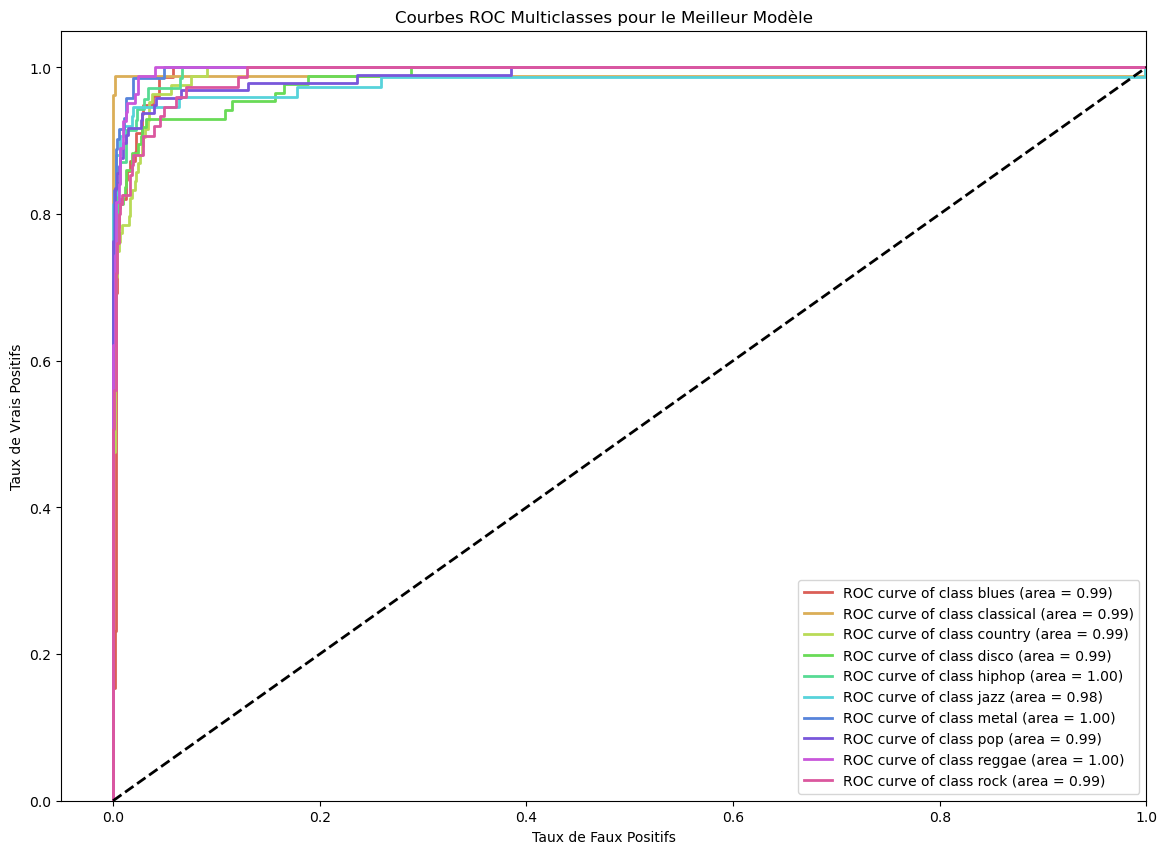

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binariser les labels
y_true_binarized = label_binarize(y_true, classes=np.arange(len(encoder.classes_)))
y_pred_proba = best_model.predict(X_test)

# Calculer les courbes ROC et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
plt.figure(figsize=(14, 10))
colors = sns.color_palette("hls", n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC Multiclasses pour le Meilleur Modèle')
plt.legend(loc="lower right")
plt.show()


**Explications :**

- **Rapport de Classification** : Fournit une vue détaillée des performances du modèle par classe, y compris la précision, le rappel et le score F1.
- **Courbes ROC et AUC** : Mesurent la capacité du modèle à distinguer chaque classe par rapport aux autres. L'AUC (Area Under the Curve) est une mesure globale de performance pour chaque classe.

### 10.3. Matrice de Confusion

Bien que vous ayez déjà une matrice de confusion, vous pouvez la refaire pour le meilleur modèle avec une visualisation améliorée.

<Figure size 1200x1000 with 0 Axes>

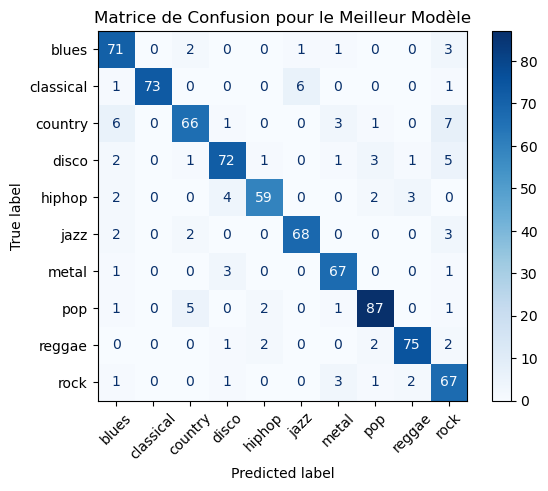

In [17]:
# Matrice de Confusion pour le Meilleur Modèle
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=encoder.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de Confusion pour le Meilleur Modèle")
plt.show()

## Étape 11 : Sauvegarder et Charger les Meilleurs Modèles

Pour réutiliser les meilleurs modèles sans avoir à les réentraîner, nous pouvons les sauvegarder et les charger ultérieurement.

### 11.1. Sauvegarde des Meilleurs Modèles

Les modèles sont déjà sauvegardés pendant l'entraînement grâce au callback `ModelCheckpoint`. Assurez-vous que les chemins des modèles sont correctement définis dans les résultats.

### 11.2. Chargement d'un Modèle Sauvegardé

Voici comment charger un modèle sauvegardé et l'utiliser pour faire des prédictions.

In [18]:
# Exemple de chargement d'un modèle sauvegardé
best_result = results_df.sort_values(by='accuracy', ascending=False).iloc[0]
best_model_path = f"models/n_mfcc_{best_result['n_mfcc']}/{best_result['model_type']}_bs{best_result['batch_size']}_ep{best_result['epochs']}_lr{best_result['learning_rate']}.keras"
best_model = load_model(best_model_path)
print(f"\nChargement du meilleur modèle : {best_model_path}")

# Charger l'encodeur des labels (si non déjà chargé)
encoder = joblib.load('label_encoder.joblib')


Chargement du meilleur modèle : models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr0.001.keras


### 11.3. Fonction de Prédiction

Voici une fonction de prédiction réutilisable avec le modèle chargé.

In [19]:
def predict_genre(file_path, model, encoder, fixed_length=1293, n_mfcc=40):
    """
    Prédit le genre musical d'un fichier audio.
    """
    try:
        audio, sr = librosa.load(file_path, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs = pad_or_truncate_mfcc(mfccs, fixed_length)
        mfccs = mfccs[..., np.newaxis]  # Ajouter la dimension canal
        mfccs = np.expand_dims(mfccs, axis=0)  # Ajouter la dimension batch

        # Normalisation
        mfccs = mfccs / np.max(mfccs)

        # Prédiction
        y_pred_proba = model.predict(mfccs)
        predicted_genre_index = np.argmax(y_pred_proba, axis=-1)
        predicted_genre = encoder.inverse_transform(predicted_genre_index)[0]
        return predicted_genre, y_pred_proba
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return None, None


## Étape 12 : Prédiction sur de Nouveaux Échantillons

Téléchargeons un nouvel échantillon audio depuis YouTube et effectuons une prédiction en utilisant le meilleur modèle.

In [20]:
# Télécharger un fichier audio depuis YouTube
youtube_url = "https://youtu.be/tAGnKpE4NCI?si=6me8uc6lZW-LZLrA" 
download_youtube_audio(youtube_url, "test_audio.wav")

# Faire une prédiction
predicted_genre, y_pred_proba = predict_genre("test_audio.wav", best_model, encoder, fixed_length=best_result['n_mfcc'], n_mfcc=best_result['n_mfcc'])
print(f"Le genre prédit pour 'test_audio.wav' est : {predicted_genre}")

[youtube] Extracting URL: https://youtu.be/tAGnKpE4NCI?si=6me8uc6lZW-LZLrA
[youtube] tAGnKpE4NCI: Downloading webpage
[youtube] tAGnKpE4NCI: Downloading ios player API JSON
[youtube] tAGnKpE4NCI: Downloading mweb player API JSON
[youtube] tAGnKpE4NCI: Downloading player 3bb1f723


[youtube] tAGnKpE4NCI: Downloading m3u8 information
[info] tAGnKpE4NCI: Downloading 1 format(s): 251
[download] Destination: temp_audio.webm
[download] 100% of    6.33MiB in 00:00:00 at 13.06MiB/s  
[ExtractAudio] Destination: temp_audio.wav
Deleting original file temp_audio.webm (pass -k to keep)
Audio téléchargé et sauvegardé sous : test_audio.wav
Erreur lors de la prédiction : Exception encountered when calling Sequential.call().

Input 0 of layer "dense_54" is incompatible with the layer: expected axis -1 of input shape to have value 41216, but received input with shape (1, 512)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 20, 20, 1), dtype=float32)
  • training=False
  • mask=None
Le genre prédit pour 'test_audio.wav' est : None


/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_67541/1720711677.py:13: RuntimeWarning: divide by zero encountered in divide
  mfccs = mfccs / np.max(mfccs)
/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_67541/1720711677.py:13: RuntimeWarning: invalid value encountered in divide
  mfccs = mfccs / np.max(mfccs)


### 12.1. Afficher les Probabilités de Prédiction

Vous pouvez également afficher les probabilités associées à chaque classe.

In [21]:
if y_pred_proba is not None:
    probabilities = y_pred_proba.flatten()
    genre_probabilities = dict(zip(encoder.classes_, probabilities))
    sorted_genres = sorted(genre_probabilities.items(), key=lambda x: x[1], reverse=True)

    print("\nProbabilités de prédiction par genre :")
    for genre, prob in sorted_genres:
        print(f"{genre}: {prob * 100:.2f}%")

    # Bar plot des probabilités
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(genre_probabilities.keys()), y=list(genre_probabilities.values()))
    plt.title("Probabilités de Prédiction par Genre")
    plt.xlabel("Genre")
    plt.ylabel("Probabilité")
    plt.xticks(rotation=45)
    plt.show()


## Conclusion

En suivant ce notebook structuré en blocs, vous pouvez systématiquement tester différentes combinaisons de modèles et d'hyperparamètres pour optimiser la classification des genres musicaux. Voici quelques points clés à retenir :

- **Organisation en Blocs** : Chaque étape du processus est clairement séparée, ce qui facilite la maintenance et l'expérimentation.
- **Automatisation des Tests** : L'utilisation de boucles imbriquées permet de tester efficacement toutes les combinaisons d'hyperparamètres.
- **Métriques Complètes** : En plus de la précision, le rappel et le score F1 fournissent une vue plus équilibrée des performances du modèle, surtout en cas de déséquilibre des classes.
- **Visualisation des Résultats** : Les graphiques générés permettent une analyse visuelle rapide des performances des différents modèles et hyperparamètres.
- **Sauvegarde des Modèles** : Grâce à `ModelCheckpoint`, les meilleurs modèles sont automatiquement sauvegardés, ce qui évite de perdre les performances optimales obtenues.
- **Réutilisation des Modèles** : Les modèles sauvegardés peuvent être facilement chargés pour des prédictions futures sans nécessiter un nouvel entraînement.